# Evaluation notebook for models trained on synthetic binary decision data


In [4]:
import warnings
import os
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
from ipywidgets import interact, FloatSlider, FloatText, Button, Output
from IPython.display import display

from plnn.models import AlgebraicPL
from plnn.dataset import get_dataloaders
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.io import load_model_from_directory, load_model_training_metadata
from plnn.loss_functions import select_loss_function
from plnn.optimizers import get_dt_schedule
from plnn.vectorfields import estimate_minima
from cont.plnn_bifurcations import get_plnn_bifurcation_curves

from plnn.pl import CHIR_COLOR, FGF_COLOR

In [5]:
OUTDIR = "./out/applet_bifurcation"

SEED = None
SAVE_ANIMATION = False

# Output directory
BASEOUTDIR = f"./out/trained_models_quadratic"

# Directory containing model directory
BASEDIR = "../data/trained_models/quadratic"

# Directory containing training data
DATDIRBASE = "../data/training_data/"
DATDIR = f"{DATDIRBASE}/data_phiq_1a"

# Model directory
MODEL_DIR = "model_algphiq_1a_v_kl1_20240711_014001"
MODEL_NAME = "model_algphiq_1a_v_kl1"


In [6]:
rng = np.random.default_rng(seed=SEED)

modeldir = f"{BASEDIR}/{MODEL_DIR}"

# OUTDIR = f"{BASEOUTDIR}/{MODEL_DIR}"
os.makedirs(OUTDIR, exist_ok=True)

datdir_train = f"{DATDIR}/training"
datdir_valid = f"{DATDIR}/validation"
datdir_test = f"{DATDIR}/testing"

nsims_train = np.genfromtxt(f"{datdir_train}/nsims.txt", dtype=int)
nsims_valid = np.genfromtxt(f"{datdir_valid}/nsims.txt", dtype=int)

try:
    nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)
except FileNotFoundError as e:
    msg = f"{e} Reverting to validation data instead."
    warnings.warn(msg)
    datdir_test = f"{DATDIR}/validation"
    nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)

# with open(f"{datdir_train}/sim0/args.txt", 'r') as f:
#     content_args = eval(f.read().strip())
# sigma_true = content_args.noise_args[0]

### Load the model

In [7]:
# Load the model
model, hyperparams, idx, model_name, model_fpath = load_model_from_directory(
    modeldir, 
    subdir="states",
    idx='best',
    model_class=AlgebraicPL,
    dtype=jnp.float64,
)

# Load the argument dictionary and training run dictionary
logged_args, run_dict = load_model_training_metadata(
    modeldir
)

loss_id = logged_args['loss']
loss_fn = select_loss_function(loss_id)

loss_train = run_dict['loss_hist_train']
loss_valid = run_dict['loss_hist_valid']
sigma_hist = run_dict['sigma_hist']
lr_hist = run_dict['learning_rate_hist']
dt_hist = run_dict['dt_hist']

if len(dt_hist) < len(sigma_hist):
    print("Calculuating `dt_hist` to match length of `sigma_hist`")
    try:
        dt_schedule = get_dt_schedule(logged_args['dt_schedule'], logged_args)
        dt_hist = np.array([dt_schedule(i) for i in range(len(sigma_hist))])
    except RuntimeError as e:
        print("Could not calculate `dt_hist` to match length of `sigma_hist`")
        print(e)

print(f"Loading model `{model_name}` at epoch {idx} from file: {model_fpath}.")

Calculuating `dt_hist` to match length of `sigma_hist`
Loading model `model_algphiq_1a_v_kl1` at epoch 272 from file: ../data/trained_models/quadratic/model_algphiq_1a_v_kl1_20240711_014001/states/model_algphiq_1a_v_kl1_272.pth.


### Load training data

In [9]:
train_loader, _, test_loader, train_dset, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=True,
    batch_size_test=1,
    ncells_sample=0,
    seed=rng.integers(2**32)
)

### Training process metadata
Before examining the inferred landscape, let's look at the training process metadata.

It will be helpful later to have the domain encapsulating the training data.

In [11]:
xdata = np.vstack([d[0][1] for d in train_dset] + [train_dset[-1][1]])
XYBUFFER = 1.0
XMIN, YMIN = xdata.min(axis=0)
XMAX, YMAX = xdata.max(axis=0)

XMIN, XMAX = XMIN - (XMAX - XMIN) * XYBUFFER, XMAX + (XMAX - XMIN) * XYBUFFER
YMIN, YMAX = YMIN - (YMAX - YMIN) * XYBUFFER, YMAX + (YMAX - YMIN) * XYBUFFER
print("x range:", XMIN, XMAX)
print("y range:", YMIN, YMAX)

x range: -23.91121303118659 23.594665425711522
y range: -47.94863654090355 48.645296238137504


In addition, we can look at the coverage of the signaling profiles.

In [12]:
TSTART = np.min([d[0][0] for d in train_dset])
TFIN = np.max([d[0][2] for d in train_dset])

k = 101
sigvals_all = []
tiltvals_all = []
signal_parameters_dict = {}  # map tuple of sigparams to start and end time
for d in train_dset:
    t0 = d[0][0]
    t1 = d[0][2]
    sigparams = d[0][-1]
    key = tuple(sigparams.flatten())
    if key in signal_parameters_dict:
        current_val = signal_parameters_dict[key]
        signal_parameters_dict[key] = (min(t0, current_val[0]), 
                                       max(t1, current_val[1]))
    else:
        signal_parameters_dict[key] = (t0, t1)
    ts = np.linspace(t0, t1, k, endpoint=True)
    sigvals = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
    tiltvals = jax.vmap(model.tilt_module)(sigvals)
    
    sigvals_all.append(sigvals)
    tiltvals_all.append(tiltvals)

sigvals_all = np.vstack(sigvals_all)
tiltvals_all = np.vstack(tiltvals_all)

In [13]:
S12BUFFER = 2.0
S1MIN, S2MIN = np.min(sigvals_all, axis=0)
S1MAX, S2MAX = np.max(sigvals_all, axis=0)
S1MIN, S1MAX = S1MIN - (S1MAX - S1MIN) * S12BUFFER, \
               S1MAX + (S1MAX - S1MIN) * S12BUFFER
S2MIN, S2MAX = S2MIN - (S2MAX - S2MIN) * S12BUFFER, \
               S2MAX + (S2MAX - S2MIN) * S12BUFFER

print("s1 range:", S1MIN, S1MAX)
print("s2 range:", S2MIN, S2MAX)

TAU12BUFFER = 2.0
TAU1MIN, TAU2MIN = np.min(tiltvals_all, axis=0)
TAU1MAX, TAU2MAX = np.max(tiltvals_all, axis=0)
TAU1MIN, TAU1MAX = TAU1MIN - (TAU1MAX - TAU1MIN) * TAU12BUFFER, \
                   TAU1MAX + (TAU1MAX - TAU1MIN) * TAU12BUFFER
TAU2MIN, TAU2MAX = TAU2MIN - (TAU2MAX - TAU2MIN) * TAU12BUFFER, \
                   TAU2MAX + (TAU2MAX - TAU2MIN) * TAU12BUFFER

print("tau1 range:", TAU1MIN, TAU1MAX)
print("tau2 range:", TAU2MIN, TAU2MAX)

s1 range: -14.755336513114703 14.728030733946127
s2 range: -14.928855559645227 14.913111364994059
tau1 range: -17.064566131950308 17.031730224465655
tau2 range: -15.212685602070035 15.200026060631115


In [14]:
A = model.get_parameters()['tilt.w'][0]
b = model.get_parameters()['tilt.b'][0]
if b is None:
    b = 0.

print("A:\n", A)
print("b:", b)

def signal_to_tilt(sig):
    if sig.ndim == 1:
        return A@sig + b
    return (A@sig.T + b).T
    
def tilt_to_signal(tilt):
    if tilt.ndim == 1:
        return np.linalg.solve(A, tilt - b)
    return np.linalg.solve(A, tilt.T - b).T

A:
 [[ 1.15645965e+00 -9.82488642e-04]
 [ 7.94278034e-04  1.01926956e+00]]
b: 0.0


interactive(children=(FloatSlider(value=0.0, description='sig1', max=14.728030733946127, min=-14.7553365131147…

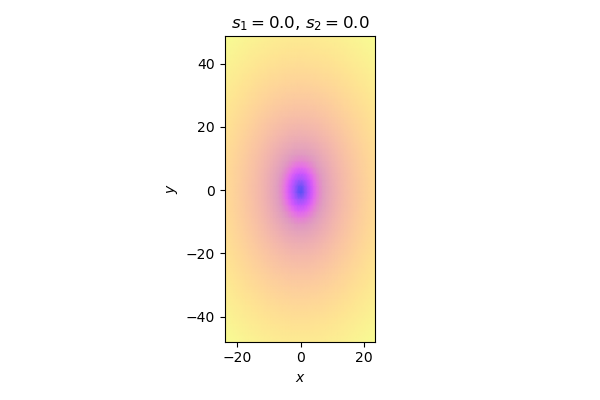

In [15]:
%matplotlib widget

S1 = 0.
S2 = 0.

ax = model.plot_phi(
    signal=[S1, S2],  # CHIR, FGF
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    show=True,
    include_cbar=False,
    title=f"$s_1={S1:.1f}$, $s_2={S2:.1f}$"
);

def update_plot(sig1, sig2):
    plt.cla()
    model.plot_phi(
        signal=[sig1, sig2],
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        show=True,
        include_cbar=False,
        ax=ax,
    )
    ax.set_title(f"$s_1={sig1:.1f}$, $s_2={sig2:.1f}$")

interact(
    update_plot, 
    sig1=FloatSlider(
        value=0., min=S1MIN, max=S1MAX, step=0.1, 
        description='sig1',
    ),
    sig2=FloatSlider(
        value=0., min=S2MIN, max=S2MAX, step=0.1, 
        description='sig2',
    )
);

## Simulation

In [16]:
_, _, aux_info = get_plnn_bifurcation_curves(
    model, 
    num_starts=10,
    p1lims=[TAU1MIN, TAU1MAX],
    p2lims=[TAU2MIN, TAU2MAX],
    # xstarts=[[x, None] for x in bifs],
    xlims=[XMIN, XMAX],
    ylims=[YMIN, YMAX],
    color=None,
    maxiter=10000,
    ds=1e-3,
    min_ds=1e-8,
    max_ds=1e-2,
    max_delta_p=1e-2,
    rho=1e-1,
    seed=rng.integers(2**32),
    return_aux_info=True,
    verbosity=0,
)

# Interactive Bifurcation Diagram Applet

In [17]:
mins_cache = None

In [18]:
xrange = [XMIN, XMAX]
yrange = [YMIN, YMAX]

taux_lims = [TAU1MIN, TAU1MAX]
tauy_lims = [TAU2MIN, TAU2MAX]
nx = 10
ny = 10

taux_arr = np.linspace(*taux_lims, nx)
tauy_arr = np.linspace(*tauy_lims, ny)
tauxs, tauys = np.meshgrid(taux_arr, tauy_arr)

mins_cache = {}

Button(description='Halt', style=ButtonStyle())

Output()

Button(description='Reset limits', style=ButtonStyle())

Output()

Button(description='Fold curve search', style=ButtonStyle())

Output()

FloatText(value=0.0, description='x:')

FloatText(value=0.0, description='y:')

interactive(children=(FloatSlider(value=-1.6, description='sig1', max=16.207489528967535, min=-16.236351248892…

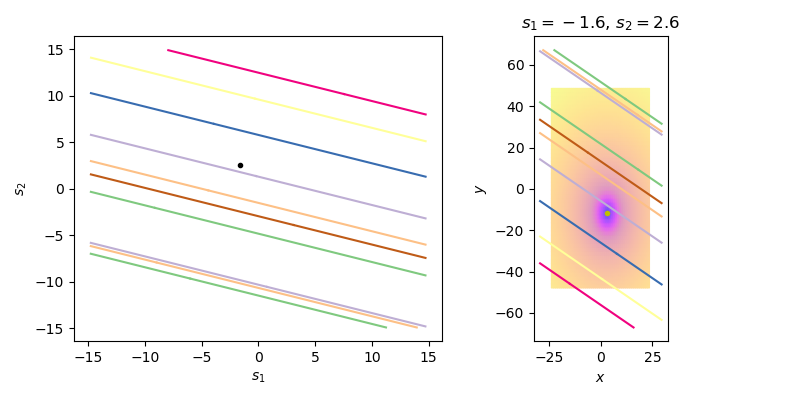

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax1 = axes[0]
ax2 = axes[1]

sig1 = -1.60
sig2 = 2.58

extra_xy_to_check = []

ax1.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])
for i in range(len(aux_info)):
    info = aux_info[i]
    if 'xs_path_fwd' in info:
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        ppath_fwd = info['ps_path_fwd'][1:]
        ppath_rev = info['ps_path_rev'][1:]
        spath_fwd = tilt_to_signal(ppath_fwd)
        spath_rev = tilt_to_signal(ppath_rev)
        l1, = ax1.plot(
            spath_fwd[:,0], spath_fwd[:,1], 
            color=None, linestyle='-', alpha=1,
        )
        color = l1.get_color()
        ax1.plot(
            spath_rev[:,0], spath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )

sigmarker, = ax1.plot([sig1], [sig2], '.k')

ax1.set_xlabel("$s_1$")
ax1.set_ylabel("$s_2$")

def update_ax1(new_aux_info):
    for i in range(len(new_aux_info)):
        info = new_aux_info[i]
        if 'xs_path_fwd' in info:
            xpath_fwd = info['xs_path_fwd'][1:]
            xpath_rev = info['xs_path_rev'][1:]
            ppath_fwd = info['ps_path_fwd'][1:]
            ppath_rev = info['ps_path_rev'][1:]
            spath_fwd = tilt_to_signal(ppath_fwd)
            spath_rev = tilt_to_signal(ppath_rev)
            l1, = ax1.plot(
                spath_fwd[:,0], spath_fwd[:,1], 
                color=None, linestyle='-', alpha=1,
            )
            color = l1.get_color()
            ax1.plot(
                spath_rev[:,0], spath_rev[:,1], 
                color=color, linestyle='-', alpha=1
            )


mins = estimate_minima(
    model, 
    signal_to_tilt(np.array([sig1, sig2], dtype=float)), 
    n=10, 
    d=2, 
    x0=None, 
    tol=1e-3,
    method="BFGS",
    opt_tol=1e-5,
    x0_range=[[XMIN, XMAX],[YMIN, YMAX]],
    sample_x0=False,
    rng=None, 
    seed=None,
)

if mins_cache is None:
    mins_cache = {}
    mins_cache[(sig1, sig2)] = mins
ax2.plot(mins[:,0], mins[:,1], '.')

model.plot_phi(
    signal=[sig1, sig2],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    show=True,
    # lognormalize=False,
    include_cbar=False,
    ax=ax2,
)


def update_plot(sig1, sig2):
    plt.sca(ax1)
    sigmarker.set_data([sig1], [sig2])
    
    plt.sca(ax2)
    plt.cla()
    model.plot_phi(
        signal=[sig1, sig2],
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        # lognormalize=False,
        show=True,
        include_cbar=False,
        ax=ax2,
    )
    ax2.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])
    for i in range(len(aux_info)):
        info = aux_info[i]
        if 'xs_path_fwd' not in info:
            continue
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        l, = ax2.plot(
            xpath_fwd[:,0], xpath_fwd[:,1], color=None, 
            linestyle='-', alpha=1.0
        )
        ax2.plot(
            xpath_rev[:,0], xpath_rev[:,1], 
            color=l.get_color(), 
            linestyle='-', alpha=1.0
        )
        
    mins = mins_cache.get((sig1, sig2), None)
    if mins is None:
        mins = estimate_minima(
            model, 
            signal_to_tilt(np.array([sig1, sig2], dtype=float)), 
            n=4, 
            d=2, 
            x0=None, 
            tol=1e-3,
            method="BFGS",
            opt_tol=1e-5,
            x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
            sample_x0=False,
            extra_x0=extra_xy_to_check,
            rng=None, 
            seed=None,
        )
        mins_cache[(sig1, sig2)] = mins

    if len(mins) > 0:
        ax2.plot(mins[:,0], mins[:,1], 'y.')
        ax2.set_title(f"$s_1={sig1:.1f}$, $s_2={sig2:.1f}$")

sig1slider = FloatSlider(
    value=sig1, min=ax1.get_xlim()[0], max=ax1.get_xlim()[1], step=0.1, 
    description='sig1',
)
sig2slider = FloatSlider(
    value=sig2, min=ax1.get_ylim()[0], max=ax1.get_ylim()[1], step=0.1, 
    description='sig2',
)

entrybox_x = FloatText(
    value=0.0,
    description='x:',
    disabled=False
)

entrybox_y = FloatText(
    value=0.0,
    description='y:',
    disabled=False
)


def onclick(event):
    global sig1, sig2
    xclick, yclick = event.xdata, event.ydata
    if event.inaxes == ax1:
        sig1, sig2 = xclick, yclick
        update_plot(sig1, sig2)
        sig1slider.value = sig1
        sig2slider.value = sig2
    elif event.inaxes == ax2:
        extra_xy_to_check.append([xclick, yclick])
        entrybox_x.value = xclick
        entrybox_y.value = yclick
    return (xclick, yclick)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

###############
##  Buttons  ##
###############

button1 = Button(description="Halt")
output1 = Output()
display(button1, output1)
def on_button1_clicked(b):
    with output1:
        fig.canvas.mpl_disconnect(cid)
button1.on_click(on_button1_clicked)


button2 = Button(description="Reset limits")
output2 = Output()
display(button2, output2)
ax1_xlims_orig = ax1.get_xlim()
ax1_ylims_orig = ax1.get_ylim()
def on_button2_clicked(b):
    with output2:
        ax1.set_xlim(*ax1_xlims_orig)
        ax1.set_ylim(*ax1_ylims_orig)
button2.on_click(on_button2_clicked)


button3 = Button(description="Fold curve search")
output3 = Output()
display(button3, output3)
def on_button3_clicked(b):
    global aux_info
    xval = entrybox_x.value
    yval = entrybox_y.value
    with output3:
        _, _, new_aux_info = get_plnn_bifurcation_curves(
            model, 
            num_starts=1,
            p1lims=ax1.get_xlim(),
            p2lims=ax2.get_xlim(),
            xstarts=[[[xval, yval], None]],
            xlims=[XMIN, XMAX],
            ylims=[YMIN, YMAX],
            color=None,
            maxiter=10000,
            ds=1e-3,
            min_ds=1e-8,
            max_ds=1e-2,
            max_delta_p=1e-2,
            rho=1e-1,
            return_aux_info=True,
            seed=rng.integers(2**32),
            verbosity=0,
        )
    aux_info += new_aux_info
    update_ax1(new_aux_info)
    update_plot(sig1, sig2)
button3.on_click(on_button3_clicked)

display(entrybox_x)
display(entrybox_y)


# buttonN = Button(description="Reset limits")
# outputN = Output()
# display(buttonN, outputN)
# def on_buttonN_clicked(b):
#     with outputN:
#         pass
# buttonN.on_click(on_buttonN_clicked)


################################################################
################################################################

interact(
    update_plot, 
    sig1=sig1slider,
    sig2=sig2slider,
);